In [59]:
from IPython.display import Markdown, display

display(Markdown("instructions.md"))

# Instructions

* Use Python
* Provide comments about your decision process, e.g. (Why have you chosen your approach or why did you choose particular model type?)
	* We are more interested in your thought process than the best possible result.
	* Can be a part of the jupyter notebook or in a separate file.
* Properly document your code.
* The output of the task should be a zip file containing the .py or .ipynb files allowing full reproducibility of your results.
* Send output to the same e-mail you have received this assignment from.


# Forecasting task

Provided dataset `sales_data.csv` contains sales data for a few articles in 2 stores.

Number of items sold, their price , promotion dummy and item category columns are provided. 

1. Perform exploratory data analysis

	* Describe the dataset, visualize, etc.
	* Comment on the data, trends you see, interesting observations you have noticed, etc. 


2. Estimate a model which predicts next days sales

	* Use proper validation scheme.
	* The type of model is up to you, you can try multiple different ones.
	* If needed construct additional features. 


3. Evaluate your models performance

	* Choose right metrics and evaluate your model. Comment on the results.


4. Provide discussion for following questions:

	* Which features do you think are the most important ones?
	* What additional data would you need to improve the model?
	* In your opinion do the provided data contain enough observations for this task?



## <font color='black'>Table of contents<font><a class='anchor' id='top'></a>
- [1. Exploratory data analysis](#1.-Exploratory-data-analysis-📊) 📊
- [2. Model](#2.-Model🛠)🛠
- [3. Model performance](#3.-Model-performance📈) 📈
- [4. Discussion](#4.-Discussion💥)💥

## 1. Exploratory data analysis 📊
* Describe the dataset, visualize, etc.
* Comment on the data, trends you see, interesting observations you have noticed, etc. 

### Importing libraries 📚

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import DateFormatter
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import plot_importance
import warnings
warnings.filterwarnings("ignore")

### Loading data 💾

In [3]:
#Loading sales_data.csv
sales =  pd.read_csv('sales_data.csv', index_col=0)
sales

,shop_id,date,item_name,n_sold,price,promotion,category
0,1,2021-01-02,cucumber,367.0,8.50,False,Vegetables
1,1,2021-01-02,bun,947.0,3.61,False,Bakery
2,1,2021-01-02,salad,459.0,9.90,False,Vegetables
3,1,2021-01-02,baguette,1343.0,3.90,False,Bakery
4,1,2021-01-03,cucumber,391.0,8.50,False,Vegetables
...,...,...,...,...,...,...,...
3224,2,2022-04-13,baguette,3245.0,4.50,False,Bakery
3225,2,2022-04-14,bun,3698.0,4.24,False,Bakery
3226,2,2022-04-14,baguette,3175.0,4.50,False,Bakery
3227,2,2022-04-15,bun,2051.0,4.18,False,Bakery


In [4]:
#Checking dataframe info
sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3229 entries, 0 to 3228
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   shop_id    3229 non-null   int64  
 1   date       3229 non-null   object 
 2   item_name  3229 non-null   object 
 3   n_sold     3227 non-null   float64
 4   price      3229 non-null   float64
 5   promotion  3229 non-null   bool   
 6   category   3229 non-null   object 
dtypes: bool(1), float64(2), int64(1), object(3)
memory usage: 179.7+ KB


In [5]:
#Let's change the data type of column date to date time
sales['date'] = pd.to_datetime(sales['date'])

In [6]:
#Checking nan values
sales.isnull().sum()

shop_id      0
date         0
item_name    0
n_sold       2
price        0
promotion    0
category     0
dtype: int64

In [7]:
#Checking nan values
sales[sales.isnull().any(axis=1)]

,shop_id,date,item_name,n_sold,price,promotion,category
590,1,2021-06-01,salad,NaN,9.9,False,Vegetables
2500,2,2021-08-14,baguette,NaN,3.9,False,Bakery


In [8]:
#Dropping nan values
sales = sales.dropna()

### Checking column promotion

In [9]:
#Let's check the promotion column
#If promotion is TRUE
sales.loc[(sales['promotion'] == True), 'price'].describe()

count    226.000000
mean       5.356814
std        2.348751
min        2.800000
25%        2.900000
50%        6.900000
75%        7.900000
max        7.900000
Name: price, dtype: float64

In [10]:
#If promotion is FALSE
sales.loc[(sales['promotion'] == False), 'price'].describe()

count    3001.000000
mean        6.201646
std         2.585995
min         0.000000
25%         3.900000
50%         4.500000
75%         8.500000
max        39.000000
Name: price, dtype: float64

In [11]:
#Let's check how the promotion influence the price values for each shop and each item
sales[sales['promotion'] == True].groupby(['item_name', 'shop_id'])['price'].median()

item_name  shop_id
bun        1          2.9
           2          2.9
cucumber   1          6.9
           2          6.9
salad      1          7.9
           2          7.9
Name: price, dtype: float64

In [12]:
#Let's check how the promotion influence the price values for each shop and each item
sales[sales['promotion'] == False].groupby(['item_name', 'shop_id'])['price'].median()

item_name  shop_id
baguette   1          3.9
           2          3.9
bun        1          3.9
           2          3.9
cucumber   1          8.5
           2          8.5
salad      1          9.9
           2          9.9
Name: price, dtype: float64

In [13]:
#Every item except the baguette had promotion
sales[sales['promotion'] == True].groupby('item_name').size()

item_name
bun         109
cucumber     29
salad        88
dtype: int64

### Creating datasets store1 and store2

In [14]:
#Let's split the dataset to two datasets based on shop_id 
store1 = sales[sales['shop_id'] == 1]
store2 = sales[sales['shop_id'] == 2]

In [15]:
#Check the sizes
print('Size of the dataset store1:' ,len(store1))
print('Size of the dataset store2:', len(store2))

Size of the dataset store1: 1615
Size of the dataset store2: 1612


In [16]:
#Let's check the first and last dates in the datasets
print('Store 1:\nFirst date', store1['date'].min().strftime('%Y-%m-%d')
, '\nLast date', store1['date'].max().strftime('%Y-%m-%d'))
print('Store 2:\nFirst date', store2['date'].min().strftime('%Y-%m-%d')
, '\nLast date', store2['date'].max().strftime('%Y-%m-%d'))

Store 1:
First date 2021-01-02 
Last date 2022-04-15
Store 2:
First date 2021-01-02 
Last date 2022-04-15


In [17]:
#Unique items for each store
print('Store 1 items:', store1['item_name'].unique())
print('Store 2 items:', store2['item_name'].unique())

Store 1 items: ['cucumber' 'bun' 'salad' 'baguette']
Store 2 items: ['cucumber' 'bun' 'salad' 'baguette']


### Checking column n_sold 

In [18]:
#Checking n_sold for store 1
store1.n_sold.describe()

count     1615.000000
mean      1355.971517
std       2165.536462
min       -295.000000
25%        523.000000
50%       1016.000000
75%       1840.500000
max      77600.000000
Name: n_sold, dtype: float64

In [19]:
#Checking n_sold for store 2
store2.n_sold.describe()

count     1612.000000
mean      2305.856079
std       2159.433388
min         11.000000
25%        855.000000
50%       1617.500000
75%       3270.750000
max      17878.000000
Name: n_sold, dtype: float64

Let's check the outliers

In [20]:
#Sorting values by n_sold
sales.sort_values(by='n_sold', ascending=True)

,shop_id,date,item_name,n_sold,price,promotion,category
890,1,2021-08-15,salad,-295.0,9.45,False,Vegetables
2053,2,2021-04-23,salad,11.0,9.90,False,Vegetables
2729,2,2021-10-12,salad,19.0,9.90,False,Vegetables
3015,2,2021-12-24,baguette,25.0,4.50,False,Bakery
2464,2,2021-08-05,baguette,55.0,3.90,False,Bakery
...,...,...,...,...,...,...,...
2590,2,2021-09-06,bun,16064.0,2.90,True,Bakery
2578,2,2021-09-03,bun,16369.0,2.90,True,Bakery
2570,2,2021-09-01,bun,17060.0,2.90,True,Bakery
2574,2,2021-09-02,bun,17878.0,2.90,True,Bakery


In [21]:
### Getting rid of outliers 
store1 = store1[(store1.n_sold >= 0 )& (store1.n_sold < 77600.0)]
sales = sales[(sales.n_sold >= 0 )& (sales.n_sold < 77600.0)]

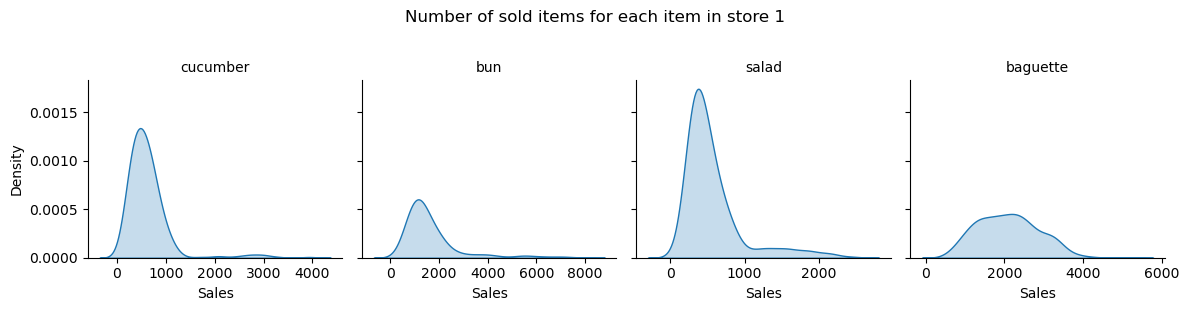

In [22]:
# Create a FacetGrid with 'item_name' as the row variable
g = sns.FacetGrid(store1, col="item_name", col_wrap=4, height=3, sharex=False)

# Map the kernel density plot onto the grid
g.map_dataframe(sns.kdeplot, x="n_sold", fill=True)

# Set titles for each subplot
g.set_titles(col_template="{col_name}")

# Add title and axis labels for the entire grid
g.fig.suptitle('Number of sold items for each item in store 1', y=1.02)
g.set_axis_labels('Sales', 'Density')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

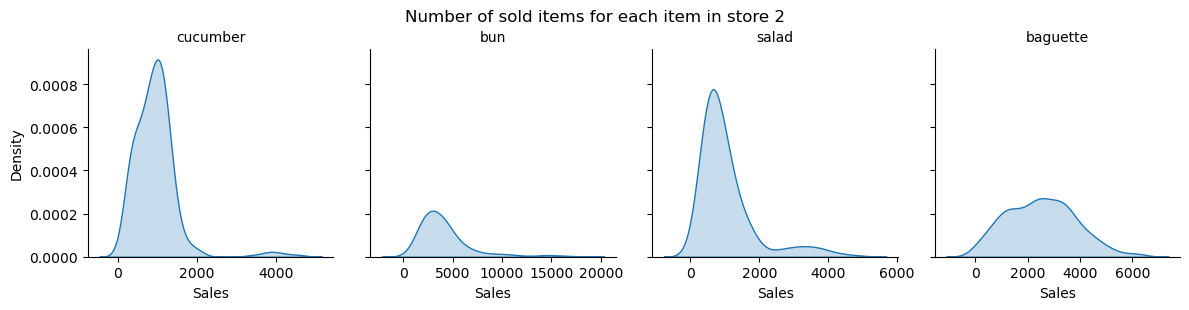

In [23]:
# Create a FacetGrid with 'item_name' as the row variable
g = sns.FacetGrid(store2, col="item_name", col_wrap=4, height=3, sharex=False)

# Map the kernel density plot onto the grid
g.map_dataframe(sns.kdeplot, x="n_sold", fill=True)

# Set titles for each subplot
g.set_titles(col_template="{col_name}")

# Add title and axis labels for the entire grid
g.fig.suptitle('Number of sold items for each item in store 2', y=1.02)
g.set_axis_labels('Sales', 'Density')
# Adjust layout
#plt.tight_layout()

# Display the plot
plt.show()

In [24]:
#Median of number of sold items for each item in store1
store1.groupby('item_name')['n_sold'].median()

item_name
baguette    2076.0
bun         1295.0
cucumber     543.0
salad        446.0
Name: n_sold, dtype: float64

In [25]:
#Median of number of sold items for each item in store2
store2.groupby('item_name')['n_sold'].median()

item_name
baguette    2478.0
bun         3449.0
cucumber     935.5
salad        794.0
Name: n_sold, dtype: float64

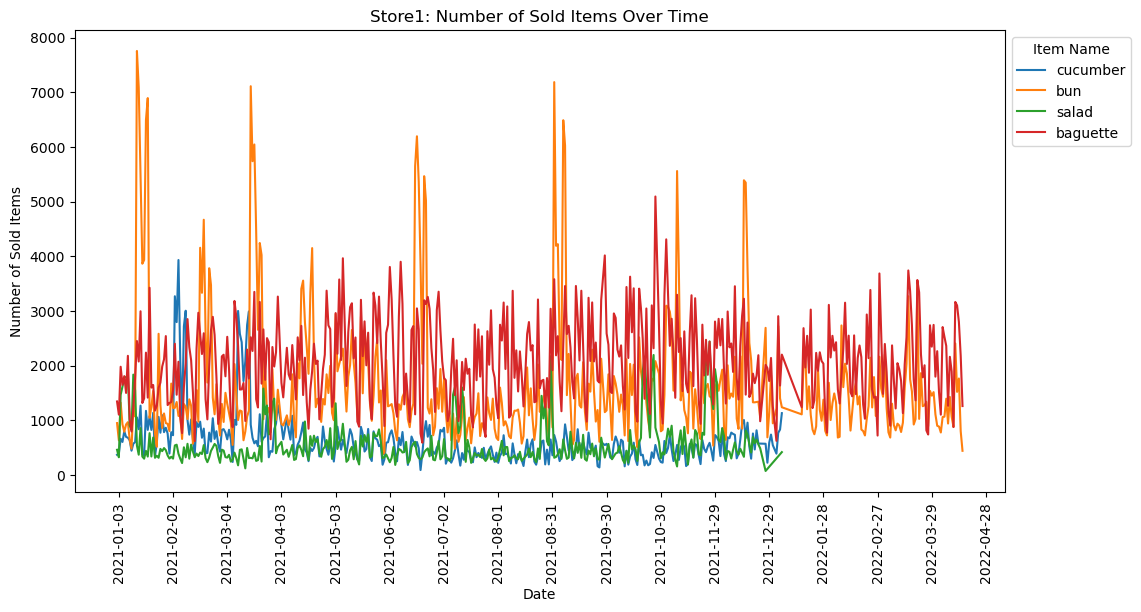

In [26]:
### Visulisation of the number of items sold in time in store 1

plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='n_sold', hue='item_name', data=store1)
plt.title('Store1: Number of Sold Items Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Sold Items')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=20))  # Adjust the number of ticks
plt.legend(title='Item Name', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [27]:
#Let's check how the promotion influence the number of sold items for each shop and each item
sales[sales['promotion'] == True].groupby(['item_name', 'shop_id'])['n_sold'].median()

item_name  shop_id
bun        1          3977.5
           2          9348.0
cucumber   1          2730.0
           2          3382.0
salad      1          1455.0
           2          2974.5
Name: n_sold, dtype: float64

In [28]:
#Let's check how the promotion influence the number of sold items for each shop and each item
sales[sales['promotion'] == False].groupby(['item_name', 'shop_id'])['n_sold'].median()

item_name  shop_id
baguette   1          2076.0
           2          2478.0
bun        1          1224.0
           2          3237.5
cucumber   1           523.0
           2           908.0
salad      1           407.5
           2           707.0
Name: n_sold, dtype: float64

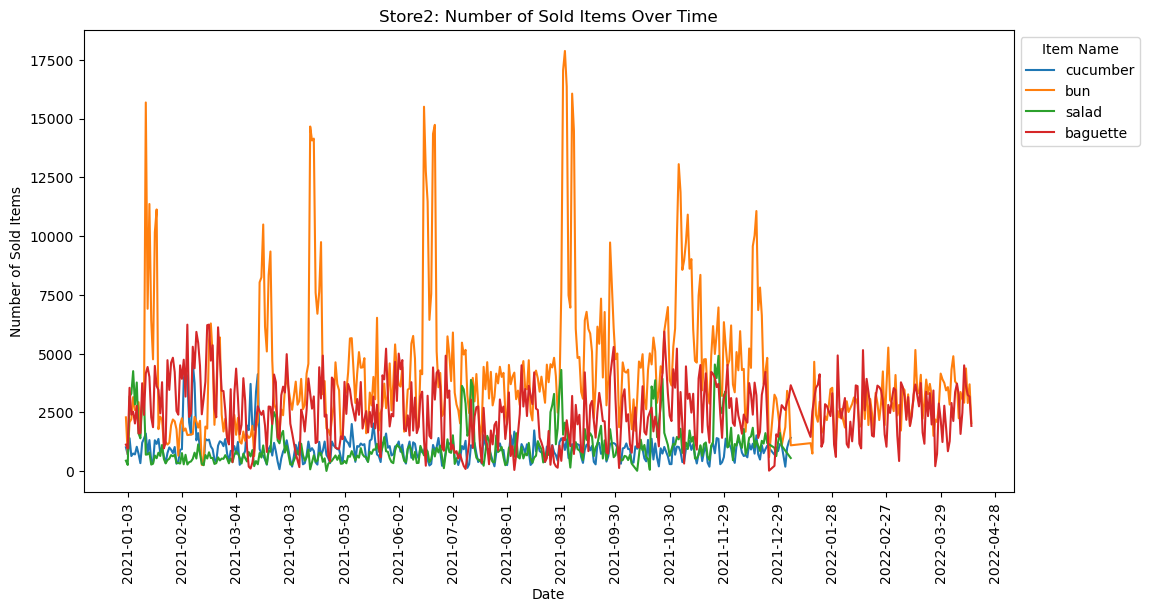

In [29]:
### Visulisation of the Number of items sold in time in store 2

plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='n_sold', hue='item_name', data=store2)
plt.title('Store2: Number of Sold Items Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Sold Items')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=20))  # Adjust the number of ticks 
plt.legend(title='Item Name', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

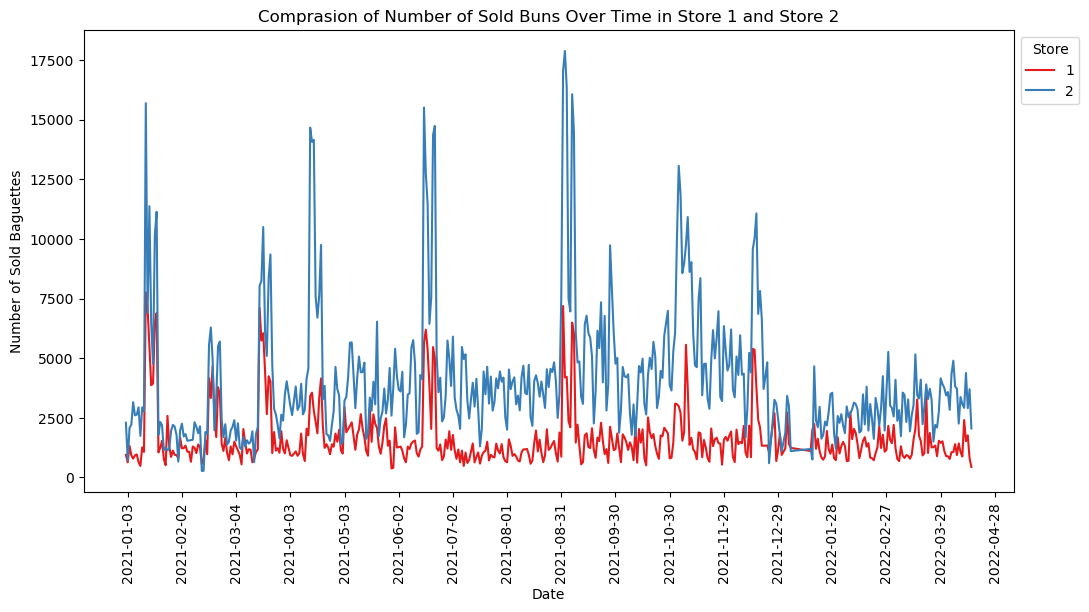

In [30]:
combined_data = pd.concat([store1, store2])

# Filter for items with the name "bun"
data = combined_data[combined_data['item_name'] == 'bun']

# Plot the data
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='n_sold', hue='shop_id', data=data,  palette='Set1')
plt.title('Comprasion of Number of Sold Buns Over Time in Store 1 and Store 2')
plt.xlabel('Date')
plt.ylabel('Number of Sold Baguettes')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=20))
plt.legend(title='Store', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.show()

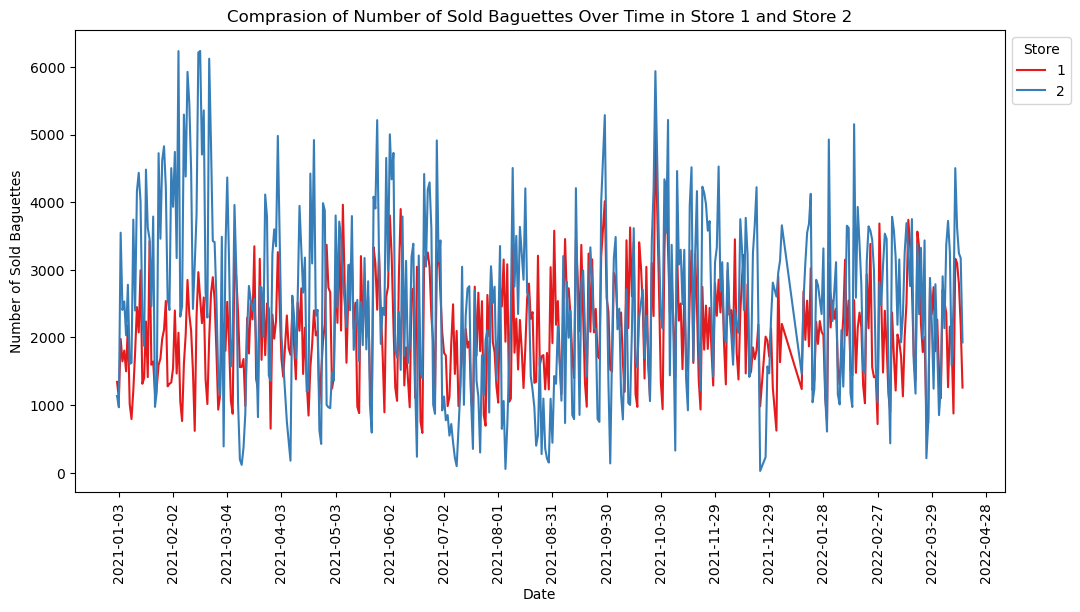

In [31]:
combined_data = pd.concat([store1, store2])

# Filter for items with the name 'baguette'
data = combined_data[combined_data['item_name'] == 'baguette']

# Plot the data
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='n_sold', hue='shop_id', data=data,  palette='Set1')
plt.title('Comprasion of Number of Sold Baguettes Over Time in Store 1 and Store 2')
plt.xlabel('Date')
plt.ylabel('Number of Sold Baguettes')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=20))
plt.legend(title='Store', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.show()

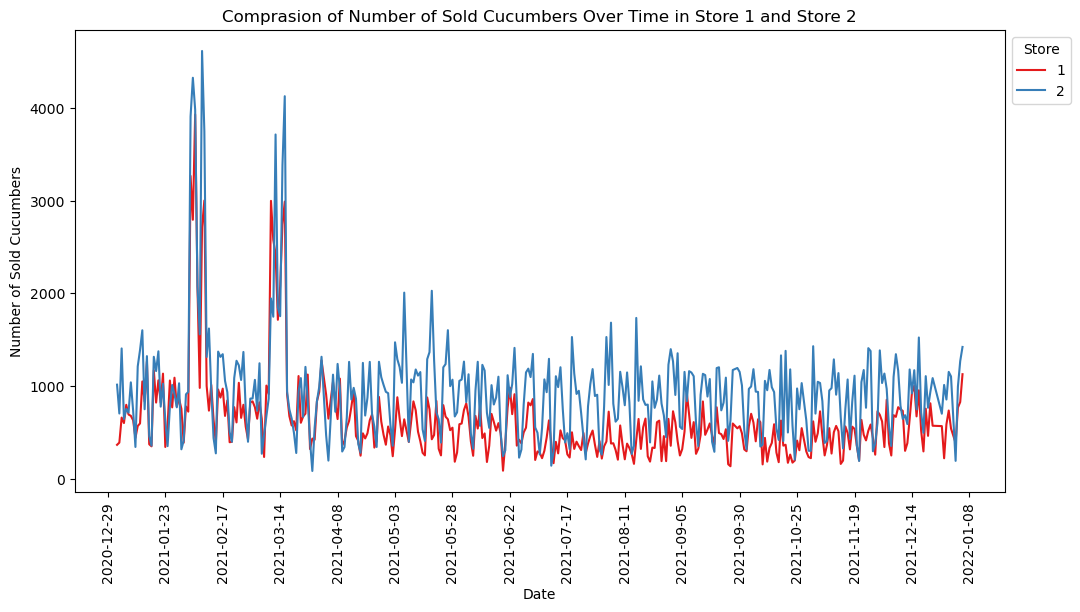

In [32]:
combined_data = pd.concat([store1, store2])

# Filter for items with the name "cucumber"
data = combined_data[combined_data['item_name'] == 'cucumber']

# Plot the data
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='n_sold', hue='shop_id', data=data,  palette='Set1')
plt.title('Comprasion of Number of Sold Cucumbers Over Time in Store 1 and Store 2')
plt.xlabel('Date')
plt.ylabel('Number of Sold Cucumbers')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=20))
plt.legend(title='Store', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.show()

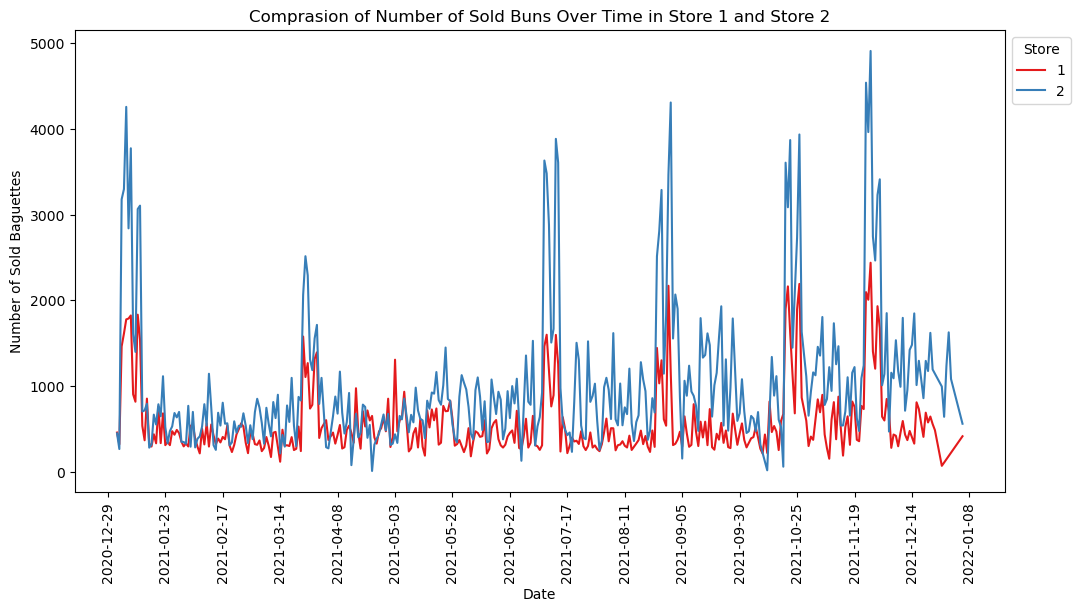

In [33]:
combined_data = pd.concat([store1, store2])

# Filter for items with the name 'salad'
data = combined_data[combined_data['item_name'] == 'salad']

# Plot the data
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='n_sold', hue='shop_id', data=data,  palette='Set1')
plt.title('Comprasion of Number of Sold Buns Over Time in Store 1 and Store 2')
plt.xlabel('Date')
plt.ylabel('Number of Sold Baguettes')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=20))
plt.legend(title='Store', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.show()

### Checking column price

In [34]:
store1.price.describe()

count    1613.000000
mean        6.179467
std         2.660172
min         0.000000
25%         3.900000
50%         4.500000
75%         8.500000
max        39.000000
Name: price, dtype: float64

In [35]:
store2.price.describe()

count    1612.000000
mean        6.101954
std         2.494520
min         2.570000
25%         3.900000
50%         4.500000
75%         8.500000
max         9.900000
Name: price, dtype: float64

Store 1 has a minimal value of price 0 and maximal 39 -> Let's check outliers

In [36]:
sales.sort_values(by='price', ascending=True)

,shop_id,date,item_name,n_sold,price,promotion,category
119,1,2021-01-31,baguette,1314.0,0.00,False,Bakery
2692,2,2021-10-02,baguette,137.0,2.57,False,Bakery
2811,2,2021-11-03,bun,9973.0,2.80,True,Bakery
2815,2,2021-11-04,bun,13063.0,2.80,True,Bakery
2827,2,2021-11-07,bun,8972.0,2.83,True,Bakery
...,...,...,...,...,...,...,...
2136,2,2021-05-15,salad,602.0,9.90,False,Vegetables
630,1,2021-06-11,salad,603.0,9.90,False,Vegetables
1250,1,2021-11-15,salad,524.0,9.90,False,Vegetables
2415,2,2021-07-24,salad,397.0,9.90,False,Vegetables


In [37]:
### Getting rid of outliers
sales = sales[(sales.price > 0 )& (sales.price < 39)]
store1 = store1[(store1.price > 0 )& (store1.price < 39)]
store2 = store2[(store2.price > 0 )& (store2.price < 39)]

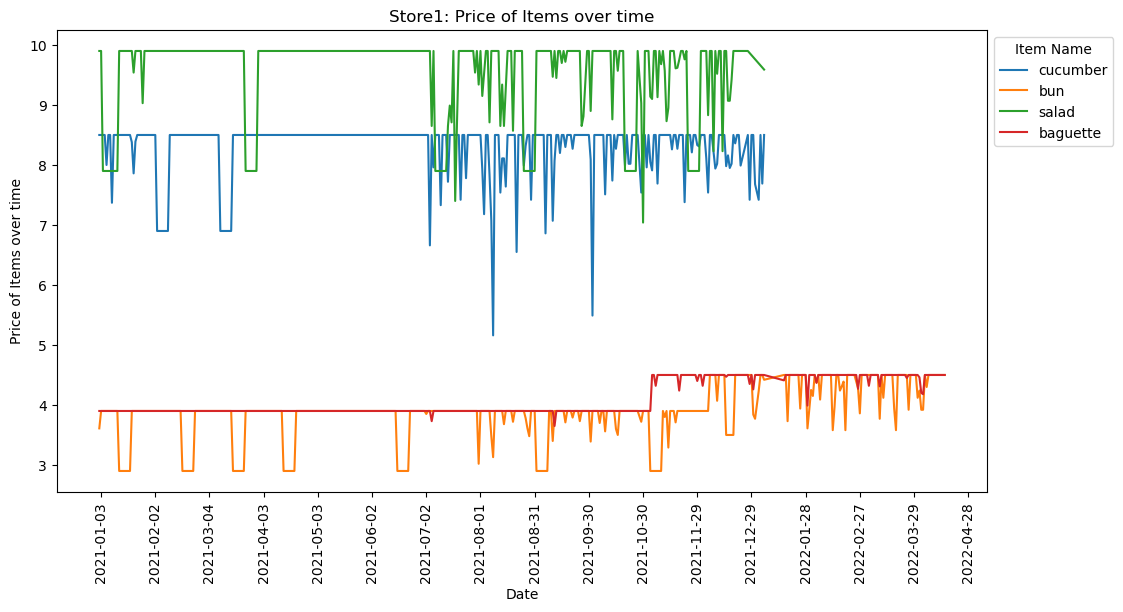

In [38]:
### Visulisation of the number of items sold in time in store 1

plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='price', hue='item_name', data=store1)
plt.title('Store1: Price of Items over time')
plt.xlabel('Date')
plt.ylabel('Price of Items over time')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=20))  # Adjust the number of ticks
plt.legend(title='Item Name', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

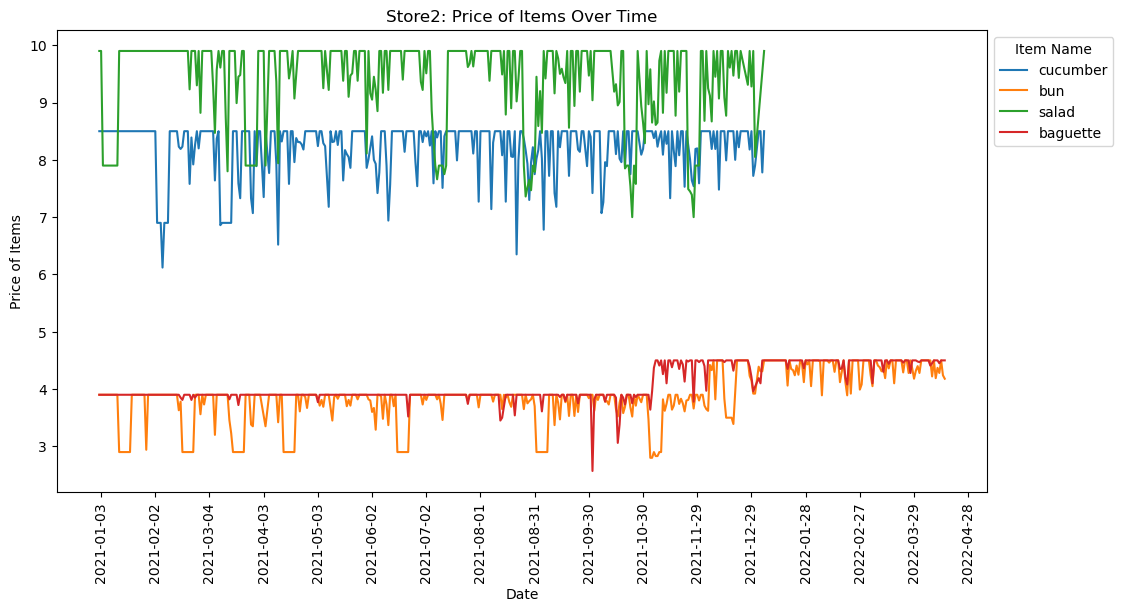

In [39]:
### Visulisation of the number of items sold in time in store 1

plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='price', hue='item_name', data=store2)
plt.title('Store2: Price of Items Over Time')
plt.xlabel('Date')
plt.ylabel('Price of Items')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=20))  # Adjust the number of ticks
plt.legend(title='Item Name', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [40]:
# Finding the index of the last occurrence of 'salad' and 'cucumber' in the 'item_name' column
last_occurrence_index = store1[store1['item_name'] == 'salad'].index.max()
last_occurrence_index1 = store1[store1['item_name'] == 'cucumber'].index.max()

# Getting the last row with the specified occurrence
print('Store 1')
print('Last occurrence of salad:',store1.iloc[last_occurrence_index]['date'].strftime('%Y-%m-%d'), '\nLast occurrence of cucumber:',store1.iloc[last_occurrence_index1]['date'].strftime('%Y-%m-%d'))

Store 1
Last occurrence of salad: 2022-01-17 
Last occurrence of cucumber: 2022-01-16


In [41]:
store2 = store2.reset_index(drop=True)

# Finding the index of the last occurrence of 'salad' and 'cucumber' in the 'item_name' column
last_occurrence_index = store2[store2['item_name'] == 'salad'].index.max()
last_occurrence_index1 = store2[store2['item_name'] == 'cucumber'].index.max()

# Getting the last row with the specified occurrence
print('Store 2')
print('Last occurrence of salad:',store2.iloc[last_occurrence_index]['date'].strftime('%Y-%m-%d'), 
     '\nLast occurrence of cucumber:',store2.iloc[last_occurrence_index1]['date'].strftime('%Y-%m-%d'))

Store 2
Last occurrence of salad: 2022-01-05 
Last occurrence of cucumber: 2022-01-05


## 2. Model🛠
* Use proper validation scheme.
* The type of model is up to you, you can try multiple different ones.
* If needed construct additional features. 

In [42]:
sales.sort_values(by='date', inplace=True)
sales.reset_index(drop=True, inplace=True)

##### Additional features

In [43]:
#Getting additional features 
sales.loc[:, "day"]= sales["date"].dt.day
sales.loc[:,"month"] = sales["date"].dt.month
sales.loc[:,'dayofweek'] = sales['date'].dt.dayofweek
sales.loc[:,'year'] = sales['date'].dt.year
sales.loc[:,'dayofyear'] = sales['date'].dt.dayofyear

In [44]:
# One hot encoding for item_name, category and shop_id features
sales = pd.get_dummies(data=sales, columns=['item_name', 'category', 'shop_id'])
sales = sales.replace(regex={False: 0, True: 1})

In [45]:
# Set a reference date
reference_date = pd.Timestamp('2021-01-02')

# Calculate the number of months that have passed from the reference date
sales.loc[:,'months_passed'] = (sales['date'].dt.to_period('M') - reference_date.to_period('M')).apply(lambda x: x.n)

In [46]:
correlation_matrix = sales.corr()

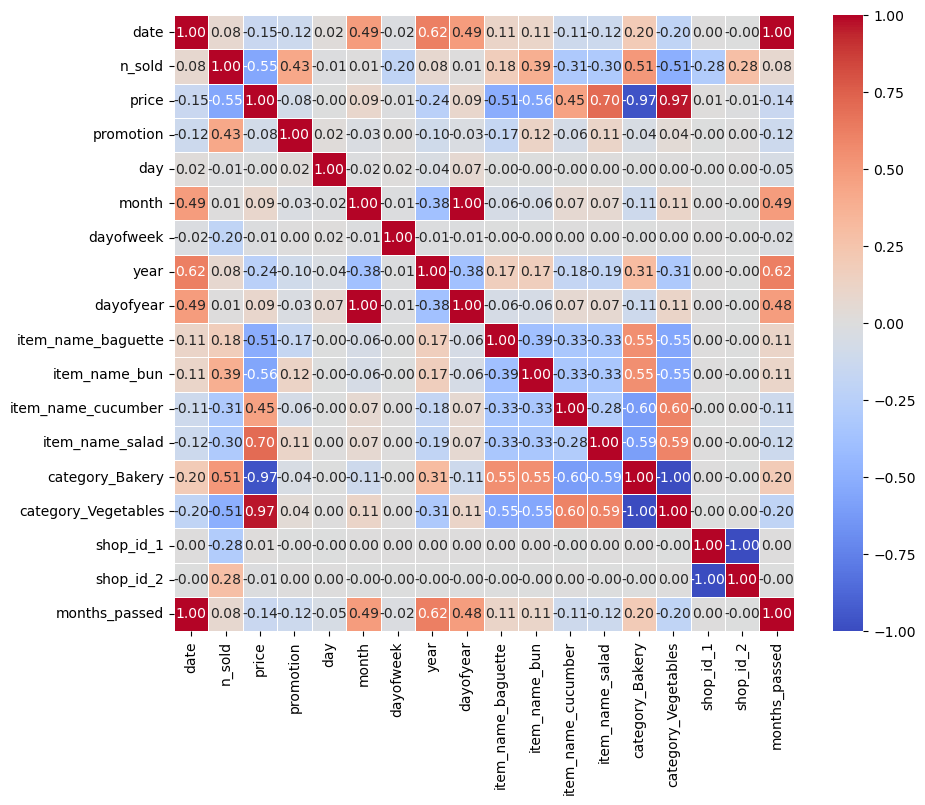

In [47]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Show the plot
plt.show()

### Train-test splitting the dataset

In [48]:
sales

,date,n_sold,price,promotion,day,month,dayofweek,year,dayofyear,item_name_baguette,item_name_bun,item_name_cucumber,item_name_salad,category_Bakery,category_Vegetables,shop_id_1,shop_id_2,months_passed
0,2021-01-02,367.0,8.50,0,2,1,5,2021,2,0,0,1,0,0,1,1,0,0
1,2021-01-02,1134.0,3.90,0,2,1,5,2021,2,1,0,0,0,1,0,0,1,0
2,2021-01-02,449.0,9.90,0,2,1,5,2021,2,0,0,0,1,0,1,0,1,0
3,2021-01-02,2293.0,3.90,0,2,1,5,2021,2,0,1,0,0,1,0,0,1,0
4,2021-01-02,1016.0,8.50,0,2,1,5,2021,2,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3218,2022-04-14,3175.0,4.50,0,14,4,3,2022,104,1,0,0,0,1,0,0,1,15
3219,2022-04-15,2051.0,4.18,0,15,4,4,2022,105,0,1,0,0,1,0,0,1,15
3220,2022-04-15,440.0,4.50,0,15,4,4,2022,105,0,1,0,0,1,0,1,0,15
3221,2022-04-15,1259.0,4.50,0,15,4,4,2022,105,1,0,0,0,1,0,1,0,15


Since the data are time series data, we have to split the them in  a way  that preserves the temporal order. The data starts at 2021-01-02 and end at 2022-04-15. (The last occurence of the vegetable in the dataset is 2022-01-17, which I would still like to include in the test set). Let's split the dataset using the train_test_split function and shuffle=False, ensuring the order of tha data is preserved. Training data contains the first 11 months and the test set the rest.

In [49]:
X = sales.drop(['date','n_sold'], axis=1)
#X = X.drop('date', axis=1)
y = sales['n_sold']

In [50]:
# Convert to NumPy array and reshape for StandardScaler
Y_reshaped = y.to_numpy().reshape(-1, 1)

# Standardization
scaler_standard = StandardScaler()
y_scaled_standard = scaler_standard.fit_transform(Y_reshaped)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X,y_scaled_standard , test_size=0.2, shuffle=False, random_state=42)

In [52]:
X_train

,price,promotion,day,month,dayofweek,year,dayofyear,item_name_baguette,item_name_bun,item_name_cucumber,item_name_salad,category_Bakery,category_Vegetables,shop_id_1,shop_id_2,months_passed
0,8.50,0,2,1,5,2021,2,0,0,1,0,0,1,1,0,0
1,3.90,0,2,1,5,2021,2,1,0,0,0,1,0,0,1,0
2,9.90,0,2,1,5,2021,2,0,0,0,1,0,1,0,1,0
3,3.90,0,2,1,5,2021,2,0,1,0,0,1,0,0,1,0
4,8.50,0,2,1,5,2021,2,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2573,4.50,0,26,11,4,2021,330,1,0,0,0,1,0,1,0,10
2574,7.39,1,26,11,4,2021,330,0,0,0,1,0,1,0,1,10
2575,4.50,0,26,11,4,2021,330,1,0,0,0,1,0,0,1,10
2576,7.64,0,26,11,4,2021,330,0,0,1,0,0,1,0,1,10


In [53]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
#Use XGBRegressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [55]:
#Prediction
y_pred = model.predict(X_test)

## 3. Model performance📈
* Choose right metrics and evaluate your model. Comment on the results.

In [56]:
#Performance metrics 
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred)}")
print(f'Root Mean Squared Error (RMSE):, {mean_squared_error(y_test, y_pred, squared=False)}')

MAE: 0.3960733674541793
MSE: 0.36614511263087285
MAPE: 4.008380963223134
Root Mean Squared Error (RMSE):, 0.6050992584947307


I'd use typical metrics for the regression model, it seems that model performed quite well, a MAPE less than 5% is considered as an indication that the prediction is acceptably accurate.

## 4. Discussion💥
1) Which features do you think are the most important ones?
2) What additional data would you need to improve the model?
3) In your opinion do the provided data contain enough observations for this task?

#### Why have you chosen your approach or why did you choose particular model type?

The XGBoostRegressor is able to capture the complex relationships in the data, also provides a mechanism to evaluate feature importance and it is quite easy to use.

#### 1. Important features

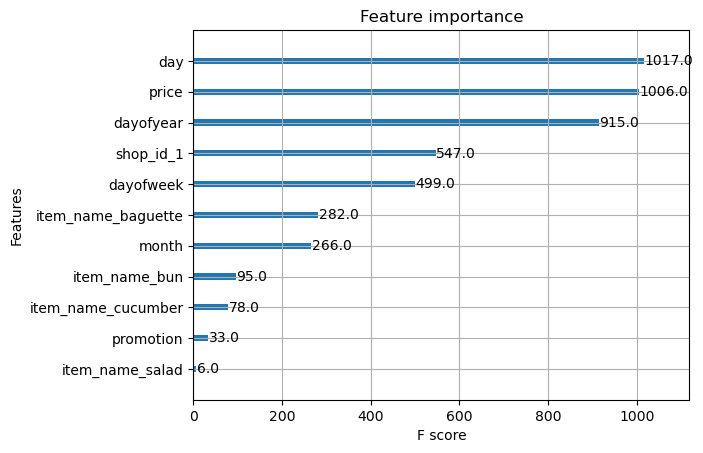

In [57]:
plot_importance(model)
plt.show()

#### 2. Additional data for model improvment: 
Temperature, Holidays, Marketing

##### 3. Do we have enough observations?
We have just one year - It would come in handy to have a representation of more years.